In [1]:
import sys
sys.path.append('/home/mayalaidler/seticore/python/')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import capnp
import viewer 
import pandas as pd
import seaborn as sns
import re

kj/filesystem-disk-unix.c++:1734: warning: PWD environment variable doesn't match current directory; pwd = /mnt_home/mayalaidler


## Load in filepaths

In [2]:
#Load in files 
fn01 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/MeerKAT-array_1-20240520T013741Z-original.bfr5'
fn02 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band00.beam00.h5'
fn03 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.hits'
fn04 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.stamps'

filename01 = '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.band01.beam41.h5'
filename02 = '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.band01.beam00.h5'
beaminco = '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.band01.incoherent.h5'
filename04 = '/datax/scratch/danielc/jwst-test-data/MeerKAT-array_1-20240520T013741Z.bfr5'
filename05 = '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.hits'
filename06 = '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.stamps'

beam0 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam00.h5'
beam6 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam06.h5'
beam7 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam07.h5'
beam8 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam08.h5'
beam40 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam40.h5'
beam62 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam62.h5'

hitsFromSeti = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.hits'

#ran seticore on beam00

newhits = 'newhits.hits'

## Read_hits function to load in a hits file to a Pandas Dataframe

In [3]:
#Make the pandas dataframe
hit_capnp = capnp.load('/mnt_home/mayalaidler/seticore/hit.capnp')

# Define a function to read the .hits file
def read_hits(filename):
    with open(filename, 'rb') as f:
        hits = hit_capnp.Hit.read_multiple(f)
        data = [hit.to_dict()['filterbank'] for hit in hits]
        f.seek(0,0)
        hits = hit_capnp.Hit.read_multiple(f)
        data2 = [hit.to_dict()['signal'] for hit in hits]
        d = pd.DataFrame(data)
        d2 = pd.DataFrame(data2)
        d3 = pd.concat([d, d2], axis = 1, join = 'outer')
    return d3

# Load the .hits file as a pandas DataFrame
df3 = read_hits(fn03)
highSNR = np.where(df3['snr'] > 11000)[0]

idx = highSNR[0]
print(idx)
start_channel = (df3['startChannel'].iloc[idx])
num_channels = (df3['numChannels'].iloc[idx]) 
foff = df3['foff'].iloc[idx]
fch1 = (df3['fch1'].iloc[idx])

beam00 = read_hits('/home/mayalaidler/seticore.output/band01.beam00.hits')


467


## Function to load h5  file and function to combine channels

In [4]:
#Load h5 file
def load_h5(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        data = h5_file["data"][()]
        # Assuming the data has a shape of (time, beam, frequency)
        data = data[:, 0, :]  # Remove the middle dimension if it has a size of 1
        return data

def combine_channels(data, factor=512):
    if data.shape[1] % factor != 0:
        raise ValueError("Number of channels must be divisible by the factor.")
    return data.reshape(data.shape[0], data.shape[1] // factor, factor).sum(axis=2)

## Load all of the beam files I'm working with combine channels and make a dictionary

In [5]:
beam0data = combine_channels(load_h5(beam0))
beam6data = combine_channels(load_h5(beam6))
beam7data = combine_channels(load_h5(beam7))
beam8data = combine_channels(load_h5(beam8))
beam40data = combine_channels(load_h5(beam40))
beam62data = combine_channels(load_h5(beam62))
beamincodata = combine_channels(load_h5(beaminco))


beam_data = [beam0data, beam6data, beam7data, beam8data, beam40data, beam62data, beaminco]

beam_datadict = {
    'Beam 0': beam0data,
    'Beam 6': beam6data,
    'Beam 7': beam7data,
    'Beam 8': beam8data,
    'Beam 40': beam40data,
    'Beam 62': beam62data,
    'Beam inco': beamincodata
}

In [6]:
tsamp = 0

with h5py.File(beam40, 'r') as f:
    keys = list(f.keys())
    tsamp = f["data"].attrs["tsamp"]
tsamp

4.9085340525714285

## Normalized Total Power Time Series for Selected Beam

[78783, 78763, 78763, 78773, 78755, 78778]
[(78728, 78823), (78708, 78803), (78708, 78803), (78718, 78813), (78700, 78795), (78723, 78818)]


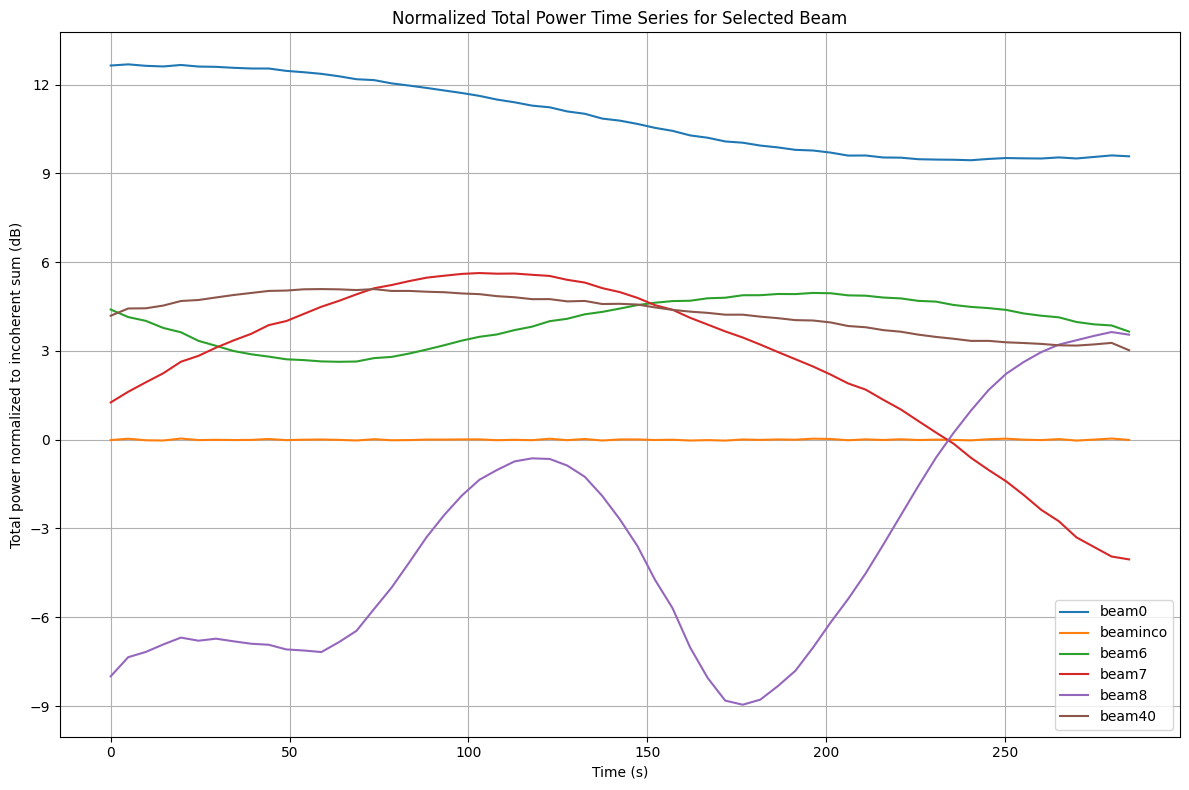

In [7]:

def combine_channels(data):
    return np.sum(data, axis=1)  # Sum channels to get total power time series

def find_main_carrier_frequency(data):
    power_spectrum = np.sum(data, axis=0)
    main_carrier_idx = np.argmax(power_spectrum)
    return main_carrier_idx

def find_channel_frequency(channel_index, fch1, foff):
    channel_frequency = fch1 + (channel_index * foff)
    return channel_frequency


def sum_data_within_range(data, range_tuple):
    start_freq, stop_freq = range_tuple
    summed_data = np.sum(data[:, start_freq:stop_freq], axis=1)
    return summed_data

def convert_channel_indices_to_frequencies(channel_ranges, fch1, foff):
    frequency_ranges = []
    for start_idx, end_idx in channel_ranges:
        start_freq = find_channel_frequency(start_idx, fch1, foff) * 1e6
        end_freq = find_channel_frequency(end_idx, fch1, foff) * 1e6
        frequency_ranges.append((start_freq, end_freq))
        
    return frequency_ranges
# Load and combine data for each beam
beam_files = [beam0, beaminco, beam6, beam7, beam8, beam40]
beam_names = ['beam0', 'beaminco', 'beam6', 'beam7', 'beam8', 'beam40']
beam_channels = [find_main_carrier_frequency(load_h5(beam)) for beam in beam_files]
print(beam_channels)

#Hz to 55 channels 
ranges3 = [((beam - (55/ foff / 1e6)), (beam + (40/foff/1e6))) for beam in beam_channels]
ranges = [(beam - 55, beam + 40) for beam in beam_channels]
beam_data = [sum_data_within_range(load_h5(beam), range) for beam, range in zip(beam_files, ranges)]

# Total power time series for the incoherent beam 
incoherent_total_power = load_h5(beaminco)
# Normalize each beam's total power by the incoherent beam's mean and standard deviation

incoherent_mean_power = np.mean(beam_data[1])
normalized_beam_data = 10*np.log10([(data / incoherent_mean_power) for data in beam_data])

#chnage time axis to seconds 
time_indices = np.arange(59)  
time_axis = time_indices * tsamp 

print(ranges)

# Normalize each time sample of all beams by the corresponding time sample value of the incoherent beam

# Plotting the total power time series for each beam
time_steps = range(len(beam_data[0]))  # Assuming all beams have the same number of time steps

plt.figure(figsize=(12, 8))

# # Plot each beam's normalized total power
# for idx, data in enumerate(normalized_beam_data):
#     plt.plot(time_steps, data, label=beam_names[idx])
    
for idx, data in enumerate(normalized_beam_data):
    plt.plot(time_axis, data, label=beam_names[idx])

plt.xlabel('Time (s)')
plt.ylabel('Total power normalized to incoherent sum (dB)')
plt.title('Normalized Total Power Time Series for Selected Beam')
yticks = np.arange(-9, 13, 3)
plt.yticks(yticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Waterfall plot of selected beam

78785
[2270.5356150399894, 2270.5355824436992, 2270.5355824436992, 2270.5355987418443, 2270.535569405183, 2270.535606890917]
3 [(78749.25382838857, 78807.54267026286), (78729.25382838857, 78787.54267026286), (78729.25382838857, 78787.54267026286), (78739.25382838857, 78797.54267026286), (78721.25382838857, 78779.54267026286), (78744.25382838857, 78802.54267026286)]


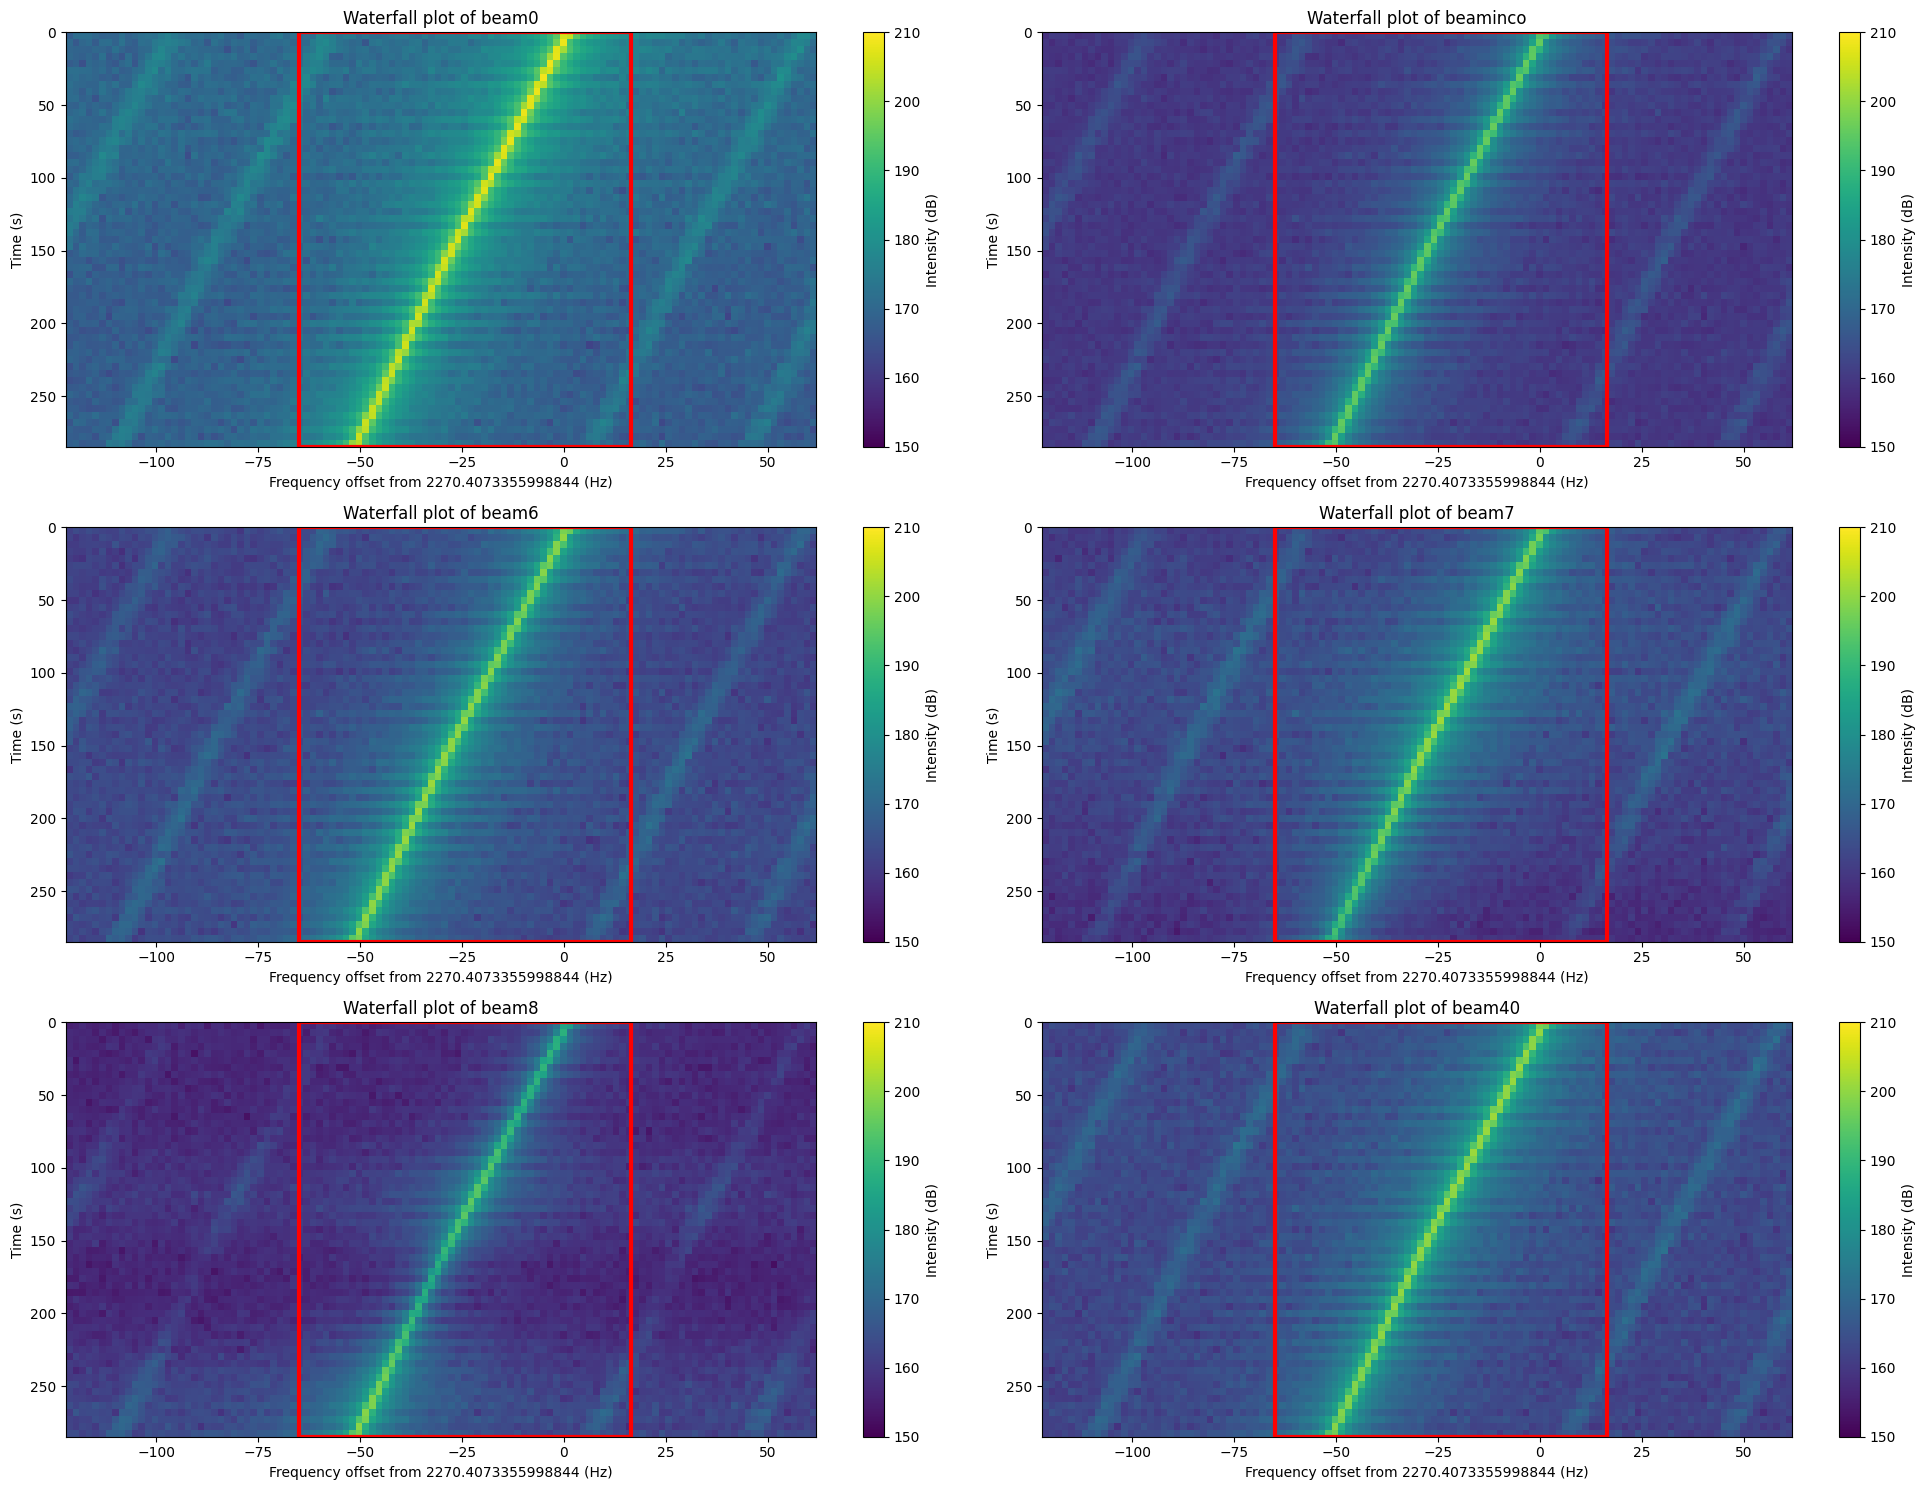

In [8]:
highSNR = np.where(df3['snr'] > 10000)[0]
import matplotlib.patches as patches

# Define a function to extract data from HDF5 file
def extract_data_from_h5(file, start_channel, num_channels):
    with h5py.File(file, 'r') as h5_file:
        data = h5_file["data"][()]  # Read the data
    # Select the subset of data
    sdata = data[:, 0, start_channel:start_channel + num_channels]
    subset_data = sdata*tsamp
    return subset_data

def find_main_carrier_frequency(data, fch1, foff):
    first_time_sample = data[0, :]  # Extract the first time sample
    main_carrier_idx = np.argmax(first_time_sample)  # Find the index with the maximum power
    main_carrier_freq = fch1 + main_carrier_idx * foff  # Calculate the frequency
    return main_carrier_freq


def create_frequency_range(fch1, foff, start_channel, num_channels):
    start_freq = fch1 + start_channel * foff
    stop_freq = start_freq + num_channels * foff
    frequencies = np.arange(start_freq, stop_freq, foff)
    return frequencies

def create_frequency_range1(fch1, foff, num_channels):
    return fch1 + np.arange(num_channels) * foff

# Function to create the frequency range
def float_range(start, stop, step):
    range_list = []
    while start < stop:
        range_list.append(round(start, 5))
        start += step
    return range_list

for idx in highSNR[:2]:
    start_channels = df3['startChannel'].iloc[idx]
    num_channels = (df3['numChannels'].iloc[idx]) 
    foff = (df3['foff'].iloc[idx])
    fch1 = (df3['fch1'].iloc[idx])
    tsamp = df3['tsamp'].iloc[idx]
    index = df3['index'].iloc[idx]

print(index)

beam_files = {
    "beam0" : '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band01.beam00.h5',
    'beaminco': '/datax/scratch/danielc/jwst-test-data/guppi_60450_05861_003791_JWST_0001.band01.incoherent.h5',
    "beam6": '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band01.beam06.h5',
    "beam7": '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band01.beam07.h5',
    'beam8': '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band01.beam08.h5',
    "beam40": '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.band01.beam40.h5',
}

# max_num_channels = df.max()['numChannels']
# startchannel = df.max()['startChannel']
# plot_index = 1

# Extract data for each beam
beam_data = {}
for beam, file in beam_files.items():
    beam_data[beam] = extract_data_from_h5(file, start_channels, num_channels)    
    # Create frequency range for the current hit
    #make it freqency offset. the channels are like 1 htz wide. Mhz has too many decimals 
    
    
fqRange = np.array(create_frequency_range(fch1, foff, start_channels, num_channels))
fqRangeMid = np.mean(fqRange)

time_indices = np.arange(data.shape[0])  
time_axis = time_indices * tsamp 


# Find the main carrier frequency for each beam
main_carrier_freqs = {beam: find_main_carrier_frequency(data, fch1, foff) for beam, data in beam_data.items()}

# Create the frequency range
fqRange = create_frequency_range1(fch1, foff, num_channels)

f  = convert_channel_indices_to_frequencies(ranges, fch1, foff)

#[(78733, 78833), (78713, 78813), (78713, 78813), (78723, 78823), (78705, 78805), (78728, 78828)]

# beam_freq2 = [((fch1 + (idx * foff)), (fch1 + (idx2 * foff))) for (idx, idx2) in ranges]

beam_freq = [(fch1 + (idx * foff)) for idx in beam_channels]
ranges2 = [((beam - foff * 40 * 1e6), (beam + foff * 10 * 1e6)) for beam in beam_freq]
print(beam_freq)
print("3", ranges3)

plt.figure(figsize=(20, 15))
for i, (beam, data) in enumerate(beam_data.items()):
    plt.subplot(3, 2, i + 1)
    main_carrier_freq = main_carrier_freqs[beam]
    # ranges = ranges - main_carrier_freq  * 1e6 
    fqRange_adjusted = (fqRange - main_carrier_freq) * 1e6  # Convert to Hz
    plt.imshow((10 * np.log10(data)), aspect='auto', cmap='viridis', vmin=150, vmax=210, extent=[fqRange_adjusted[0], fqRange_adjusted[-1], time_axis[-1], time_axis[0]])
    plt.xlabel('Frequency offset from ' + str(main_carrier_freq) + ' (Hz)')
    plt.ylabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.title(f'Waterfall plot of {beam}')
    start_freq, stop_freq = ((ranges2[i]) - main_carrier_freq)

    rect = plt.Rectangle((start_freq, 0), stop_freq - start_freq, time_axis[-1], linewidth=3, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()
# fig.savefig('waterfallofBeams.png')


In [9]:
# for data in combined_data_list:
#     plt.figure(figsize = (15,10))
#     data = np.array(df3['data'][idx]).reshape((df3['numTimesteps'].iloc[idx].values[0], df3['numChannels'].iloc[idx]))
#     im = plt.imshow(10 * np.log10(data), aspect='auto', cmap='viridis')
#     plt.colorbar(im, label='Intensity (dB)')
#     plt.xlabel('Frequency (MHz)')
#     plt.ylabel('Time Index')
#     plt.title(f'Waterfall plot')
#     plt.xlim((min -1), (max + 1))
#     plt.tight_layout()
#     plt.show()

## Normalize the Hdf5 File

In [10]:

input_file = beam0
output_file = 'normalized_filebeam00.h5'

with h5py.File(input_file, 'r') as f:
    data = f['data'][()]
    max_value = np.max(data)
    normalized_data = data / max_value

    # Open a new HDF5 file to save the normalized data
    with h5py.File(output_file, 'w') as f_out:
        # Create a dataset and save the normalized data
        f_out.create_dataset('data', data=normalized_data)

        # Copy the attributes from the original file to the new file
        for key, value in f.attrs.items():
            f_out.attrs[key] = value
            f['data'].attrs['beam'] = 0

        # If there are other datasets or groups in the original file, copy them as well
        for name in f:
            if name != 'data':
                f.copy(name, f_out)

print(f"Normalized data saved to {output_file}")

Normalized data saved to normalized_filebeam00.h5


In [11]:
def normalize_h5_file(original_file, normalized_file):
    with h5py.File(original_file, 'r') as orig_f, h5py.File(normalized_file, 'w') as norm_f:
        data = orig_f['data'][()]
        max_value = data.max()
        normalized_data = data / max_value
        print(max_value)

        # Copy data to new file
        norm_f.create_dataset('data', data=normalized_data)

        # Copy all attributes
        for attr, value in orig_f['data'].attrs.items():
            norm_f['data'].attrs[attr] = value

original_file = beam0
normalized_file = 'normalized_file.h5'

normalize_h5_file(original_file, normalized_file)

def normalize_h5_file(original_file, destination_directory, normalized_file_name):

    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)
    
    # Construct the full path for the normalized file
    normalized_file = os.path.join(destination_directory, normalized_file_name)

    with h5py.File(original_file, 'r') as orig_f, h5py.File(normalized_file, 'w') as norm_f:
        # Read the data
        data = orig_f['data'][()]
        max_value = data.max()

        # Normalize the data
        normalized_data = data / max_value
        print(f"Max value: {max_value}")

        # Create a new dataset in the normalized file and copy normalized data
        norm_f.create_dataset('data', data=normalized_data)

        # Copy all attributes from the original dataset to the new dataset
        for attr, value in orig_f['data'].attrs.items():
            norm_f['data'].attrs[attr] = value

# Define the paths and file names
original_file = 'beam0.h5'  # Update with the correct path to your file
destination_directory = '/path/to/new/directory'  # Update with the path to your destination directory
normalized_file_name = 'normalized_file.h5'  # Name of the normalized file

# Call the function to normalize the HDF5 file
normalize_h5_file(original_file, destination_directory, normalized_file_name)

1.4910405e+20


OSError: [Errno 30] Read-only file system: '/path'

In [ ]:
#Just the normalized hits of beam 00
newhitsdata = read_hits(newhits)

# ndata = np.array(newhitsdata['data']).reshape((newhitsdata['numTimesteps'].iloc[idx].values[0], newhitsdata['numChannels'].iloc[idx]))

plt.figure(figsize  = (10,20))
print(newhitsdata.keys())

snr_values = newhitsdata['snr']
freq = newhitsdata['frequency']
beam = newhitsdata['beam']
first_beam_column = beam.iloc[:, 0]
dr = newhitsdata['driftRate']


snr_values = np.log10(snr_values)
# freq = np.log10(freq)

cmap = plt.get_cmap('viridis', 63) 

# Create the scatter plot
plt.figure(figsize=(12, 8))
s = plt.scatter(freq, snr_values, c=snr_values, cmap=cmap, s=100)
plt.scatter(freq, snr_values, c = snr_values, cmap=cmap, s=100)
s
plt.xlabel('frequency (MHz)')
plt.ylabel('SNR dB')
plt.legend()
plt.title('Normalized HDf5 file of Beam 0')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'newhits.hits'

In [ ]:
newhitsdata = read_hits(newhits)
plt.figure(figsize  = (10,20))

snr_values = newhitsdata['snr']
freq = newhitsdata['frequency']
snr_values = np.log10(snr_values)

cmap = plt.get_cmap('viridis', 63) 

# Create the scatter plot
plt.figure(figsize=(12, 8))

#plot beam00
plt.scatter(freq, snr_values, label = 'beam00')


# Plot scatter plot for beam 01 as well
beam01idx = np.where(df3['beam'] == 1)[0]
filtered_df3 = df3.loc[beam01idx]
frequencies01 = filtered_df3['frequency'].values
snrs = filtered_df3['snr'].values

#Normalize snr value
def normalize_snr(snr_values):
    snr_values = np.asarray(snr_values)
 
    max_snr = max(snr_values)
    if max_snr == 0:
        raise ValueError("The maximum SNR value is zero, cannot normalize.")
    
    normalized_snr = [snr / max_snr for snr in snr_values]
    return normalized_snr

snrs = 10*np.log10(normalize_snr(snrs))

plt.scatter(frequencies01, snrs, label= "beam01")

#label plots
plt.xlabel('frequency (MHz)')
plt.ylabel('SNR dB')
plt.xlim(2270, 2271.5)
plt.legend()
plt.title('Frequency vs SNR values for Beam00 and Beam 01')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'newhits.hits'

## Normalize all the the beam files

In [ ]:
normalized_files = [normalize_h5_file(file, 'normalized' + name + '.h5') for name, file in beam_files.items()]

TypeError: normalize_h5_file() missing 1 required positional argument: 'normalized_file_name'

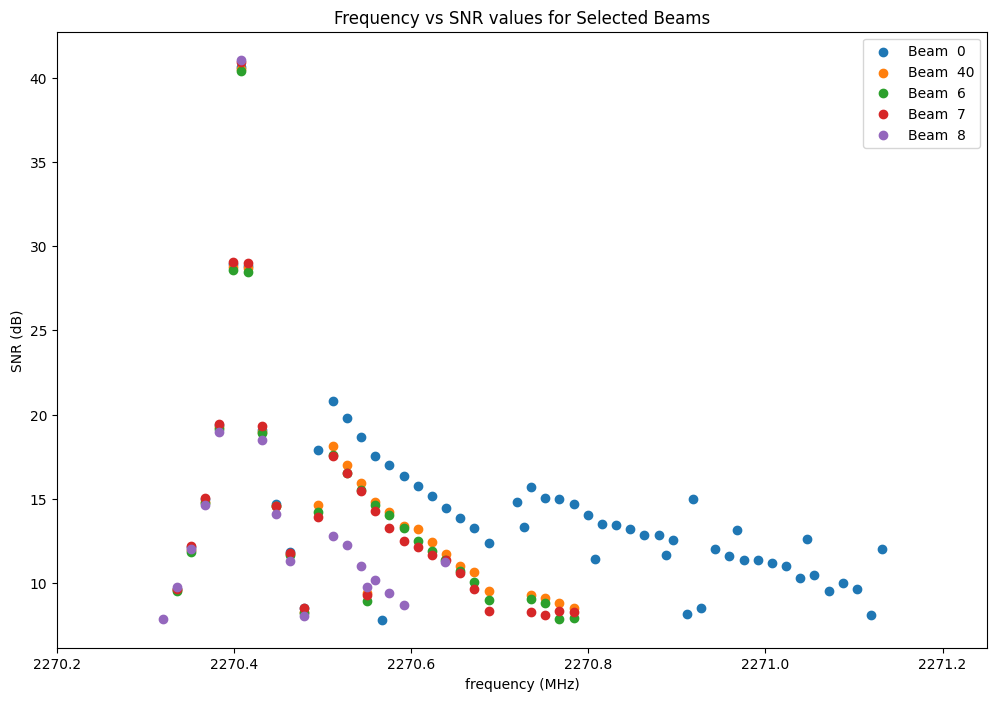

In [ ]:
# Load in all the normalized files that have been run through SetiCore
directory = '/home/mayalaidler/breakthrough/hitsFiles'

# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

for file_name in os.listdir(directory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(directory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            data = read_hits(file_path)
            
            #load in snr and freq values
            snr_values = data['snr']
            freq = data['frequency']
            snr_values = 10*np.log10(snr_values)
            
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                label = 'Beam inco'
            elif numbers:
                label = f'Beam  {", ".join(numbers)}'
            else:
                label = 'Beam 1'
            
            plt.scatter(freq, snr_values, label=label)
            
plt.xlabel('frequency (MHz)')
plt.ylabel('SNR (dB)')
plt.xlim(2270.2, 2271.25)
plt.legend()
plt.title('Frequency vs SNR values for Selected Beams')
plt.show()

## Comparing unnormalized hits to normalized hits

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


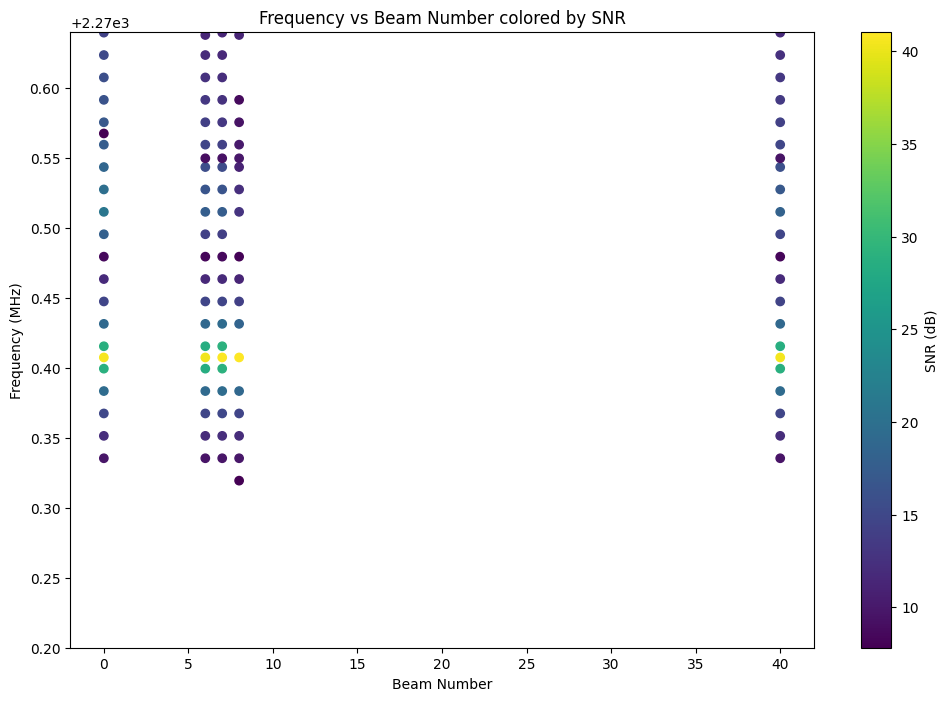

In [ ]:
directory = '/home/mayalaidler/breakthrough/hitsFiles'

# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Lists to hold the data for plotting
beam_numbers2 = []
frequencies2 = []
snr_values2 = []
beam0snr = []
beam0freq = []

for file_name in os.listdir(directory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(directory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            data = read_hits(file_path)
            
            # Load in snr and freq values
            file_snr_values = data['snr']
            file_frequencies = data['frequency']
            
            # Normalize the SNR values
            file_snr_values = 10*np.log10(file_snr_values)
            
            # Extract beam number
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                beam_number = 'inco'
            elif numbers:
                beam_number = int(numbers[0])
                if numbers == 0:
                    print('ssss')
                    beam0snr.extend(file_snr_values)
                    beam0freq.extend(file_frequencies)
            else:
                beam_number = 0
            
            # Append the data to the lists
            beam_numbers2.extend([beam_number] * len(file_frequencies))
            frequencies2.extend(file_frequencies)
            snr_values2.extend(file_snr_values)

# Create the scatter plot
scatter = plt.scatter(beam_numbers2, frequencies2, c=snr_values2, cmap='viridis')
plt.ylim(2270.2, 2270.64)
print(beam_numbers2)

plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(scatter, label='SNR (dB)')
plt.title('Frequency vs Beam Number colored by SNR')
plt.show()


## Recreate the beam number vs freq plot

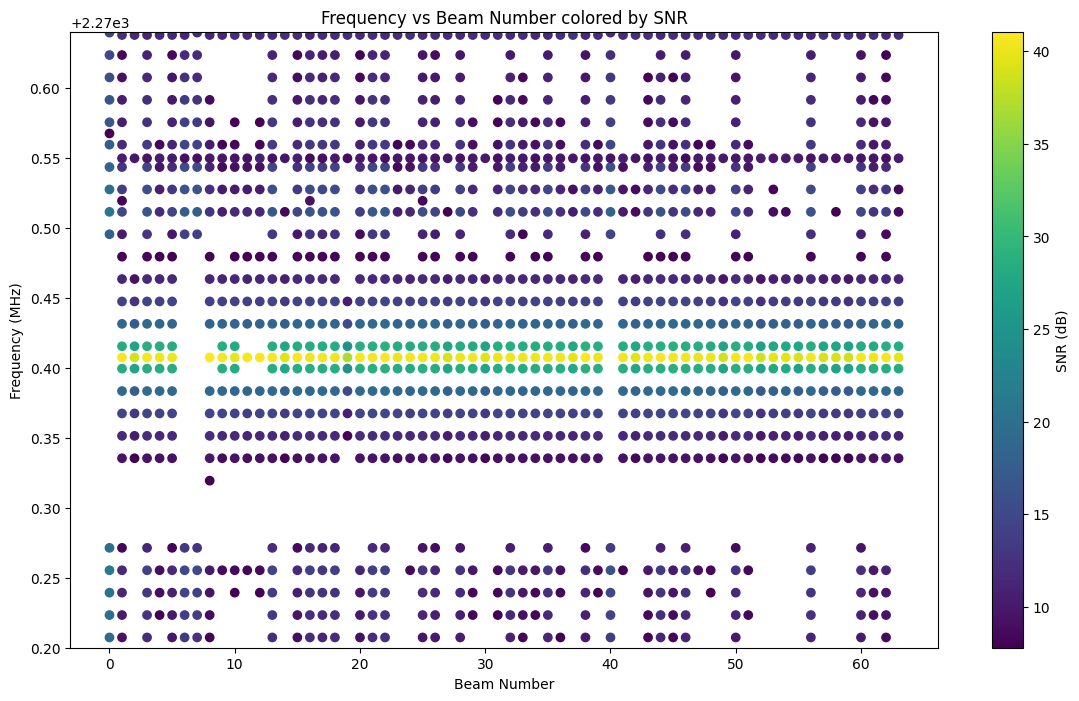

In [ ]:
plt.figure(figsize= (14, 8))
freq = df3['frequency']
snr_values = df3['snr']
snr_values = 10*np.log10(snr_values)
beam = df3['beam']
first_beam = beam.iloc[:, 0]   

         
plt.scatter(first_beam, freq, c=snr_values, cmap='viridis')

plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(label='SNR (dB)')
plt.title('Frequency vs Beam Number colored by SNR')
plt.ylim(2270.2, 2270.64)
plt.show()


## Normalize ALL of the HDf5 Files and put them in a new directory

In [ ]:
def normalize_h5_file1(original_file, destination_directory, normalized_file_name):
   
    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)
    
    # Construct the full path for the normalized file
    normalized_file = os.path.join(destination_directory, normalized_file_name)

    with h5py.File(original_file, 'r') as orig_f, h5py.File(normalized_file, 'w') as norm_f:
        # Read the data
        data = orig_f['data'][()]
        max_value = data.max()

        # Normalize the data
        normalized_data = data / max_value
        print(f"Max value: {max_value}")

        # Create a new dataset in the normalized file and copy normalized data
        norm_f.create_dataset('data', data=normalized_data)

        # Copy all attributes from the original dataset to the new dataset
        for attr, value in orig_f['data'].attrs.items():
            norm_f['data'].attrs[attr] = value

directory1 = '/mnt_blpc3/datax/scratch/jwst-test'
destination_directory = '/home/mayalaidler/breakthrough/normalizedFiles'

# #Normalized all of the beams already
# for file_name in os.listdir(directory1):
#      file_path = os.path.join(directory1, file_name)
#      if os.path.isfile(file_path):
#           #remove beam00 to deal with it seperately 
#           if 'beam00' in file_path:
#               normalized_file_name = 'normalized' + file_name
#               normalize_h5_file1(file_path, '/home/mayalaidler/breakthrough/normalizedBeam00Files', normalized_file_name)
#               print('beam00')
#           else: 
#             if 'beam00'not in file_path:
#                 # normalized_file_name = 'normalized' + file_name
#                 # normalize_h5_file1(file_path, destination_directory, normalized_file_name)  
#                 print('done')      

## Plot all of the hits from the normalized beam files

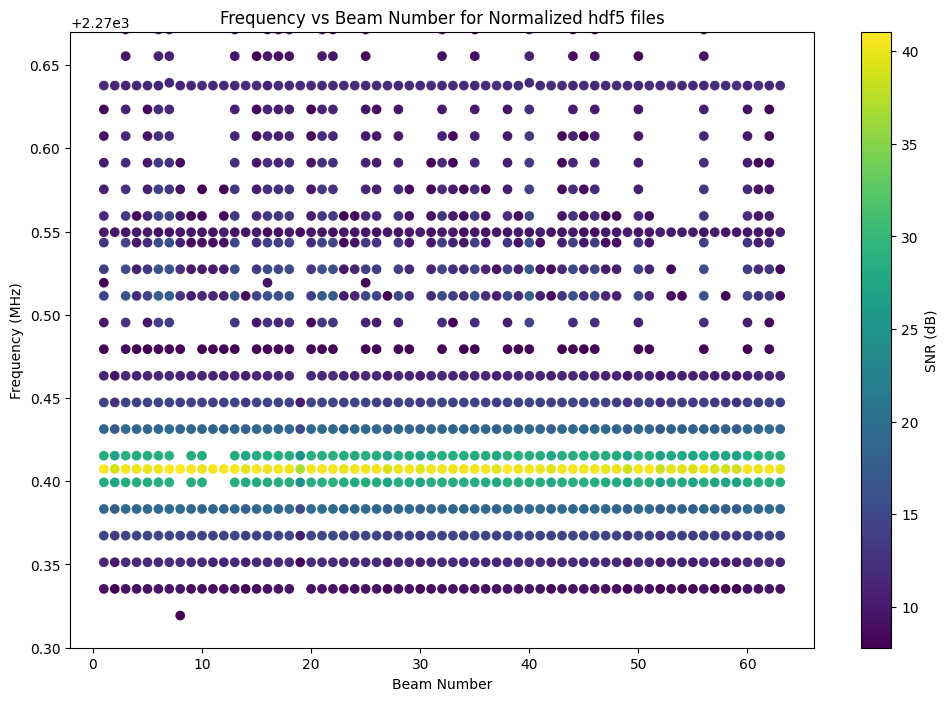

In [ ]:
hitsDirectory = '/home/mayalaidler/breakthrough/outputFiles'
mergedNormalizedpd = pd.DataFrame()  # inner, outer, left, right


# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Lists to hold the data for plotting
beam_numbers = []
frequencies = []
snr_values = []

# Initialize a list to store DataFrames
dataframes = []

for file_name in os.listdir(hitsDirectory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(hitsDirectory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            
            beam_pattern = re.compile(r'beam(\d+)')
            match = beam_pattern.search(file_name)
            if match:
                beam_number = int(match.group(1))
            else:
                print(f"No beam number found in file name: {file_name}")
                continue
            
            data = read_hits(file_path)
            data['beam'] = beam_number
            
            # Append DataFrame to the list
            dataframes.append(data)
            mergedNormalizedpd = pd.concat(dataframes, ignore_index=True)
            
            # Load in snr and freq values
            file_snr_values = data['snr']
            file_frequencies = data['frequency']
            
            # Normalize the SNR values
            file_snr_values = 10*np.log10(file_snr_values)
            
            # Extract beam number
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                beam_number = 'inco'
            elif numbers:
                beam_number = int(numbers[-1])
            else:
                beam_number = 0
            
            # Append the data to the lists
            beam_numbers.extend([beam_number] * len(file_frequencies))
            frequencies.extend(file_frequencies)
            snr_values.extend(file_snr_values)

# Create the scatter plot
scatter = plt.scatter(beam_numbers, frequencies, c=snr_values, cmap='viridis')
plt.ylim(2270.3, 2270.67)
plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(scatter, label='SNR (dB)')
plt.title('Frequency vs Beam Number for Normalized hdf5 files')
plt.show()


## Identify Hits that are in Normalized and not Normalized 

In [ ]:
# #merge two DataFrames and create indicator column
# df_all = df3.merge(mergedNormalizedpd.drop_duplicates(), on=['frequency','snr'],
#                    how='left', indicator=True)

# #create DataFrame with rows that exist in first DataFrame only
# df1_only = df_all[df_all['_merge'] == 'left_only']

dfUnnorm = df3
dfNorm = mergedNormalizedpd

hits_dfNorm = set(dfNorm[['frequency', 'beam']].itertuples(index=False, name=None))
hits_dfUnnorm = set(dfUnnorm[['frequency', 'beam']].itertuples(index=False, name=None))

# Hits in Norm but not in Unnorm
missing_hits = hits_dfNorm - hits_dfUnnorm

# Hits in Unnorm but not in Norm 

missing_hits2 = hits_dfUnnorm - hits_dfNorm

# Convert missing_hits to a DataFrame for plotting

merged_df = dfNorm[dfNorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits)]
merged_df2 = dfNorm[dfNorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits2)]

print('l', merged_df)
print('v', merged_df2)
# missing_hits_df = pd.DataFrame(list(missing_hits), columns=dfNorm.columns)

l                    sourceName         fch1      foff        tstart     tsamp  \
215  Gaia_4060289836270794752  2270.335213  0.000002  60450.067839  4.908534   
216  Gaia_4060289836270794752  2270.351213  0.000002  60450.067839  4.908534   
217  Gaia_4060289836270794752  2270.367213  0.000002  60450.067839  4.908534   
218  Gaia_4060289836270794752  2270.383213  0.000002  60450.067839  4.908534   
219  Gaia_4060289836270794752  2270.399213  0.000002  60450.067839  4.908534   
220  Gaia_4060289836270794752  2270.407215  0.000002  60450.067839  4.908534   
221  Gaia_4060289836270794752  2270.415212  0.000002  60450.067839  4.908534   
222  Gaia_4060289836270794752  2270.431214  0.000002  60450.067839  4.908534   
223  Gaia_4060289836270794752  2270.447214  0.000002  60450.067839  4.908534   
224  Gaia_4060289836270794752  2270.463214  0.000002  60450.067839  4.908534   
225  Gaia_4060289836270794752  2270.479214  0.000002  60450.067839  4.908534   
256  Gaia_4058793504024683904  2270.33

In [ ]:
# print(df3.shape)

# # Create sets of (frequency, beam) tuples
# hits_dfNorm = set(dfNorm[['frequency', 'beam']].itertuples(index=False, name=None))
# hits_dfUnnorm = set(dfUnnorm[['frequency', 'beam']].itertuples(index=False, name=None))

# # Identify hits that are in dfNorm but not in dfUnnorm
# missing_hits = hits_dfNorm - hits_dfUnnorm

# # Identify hits that are in dfUnnorm but not in dfNorm
# missing_hits2 = hits_dfUnnorm - hits_dfNorm

# # Debugging: Print the sets to check contents
# print("Missing hits in Norm but not in Unnorm:", missing_hits)
# print("Missing hits in Unnorm but not in Norm:", missing_hits2)

# # Convert missing_hits to DataFrames
# merged_df = dfNorm[dfNorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits)]
# merged_df2 = dfUnnorm[dfUnnorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits2)]

# # Debugging: Print the resulting DataFrames
# print("DataFrame with hits in Norm but not in Unnorm:")
# print(merged_df)
# print("DataFrame with hits in Unnorm but not in Norm:")
# print(merged_df2.shape)


## Plot a empty dot for every hit that is picked up by the normalized data that is not found by the unnormalized data

[]


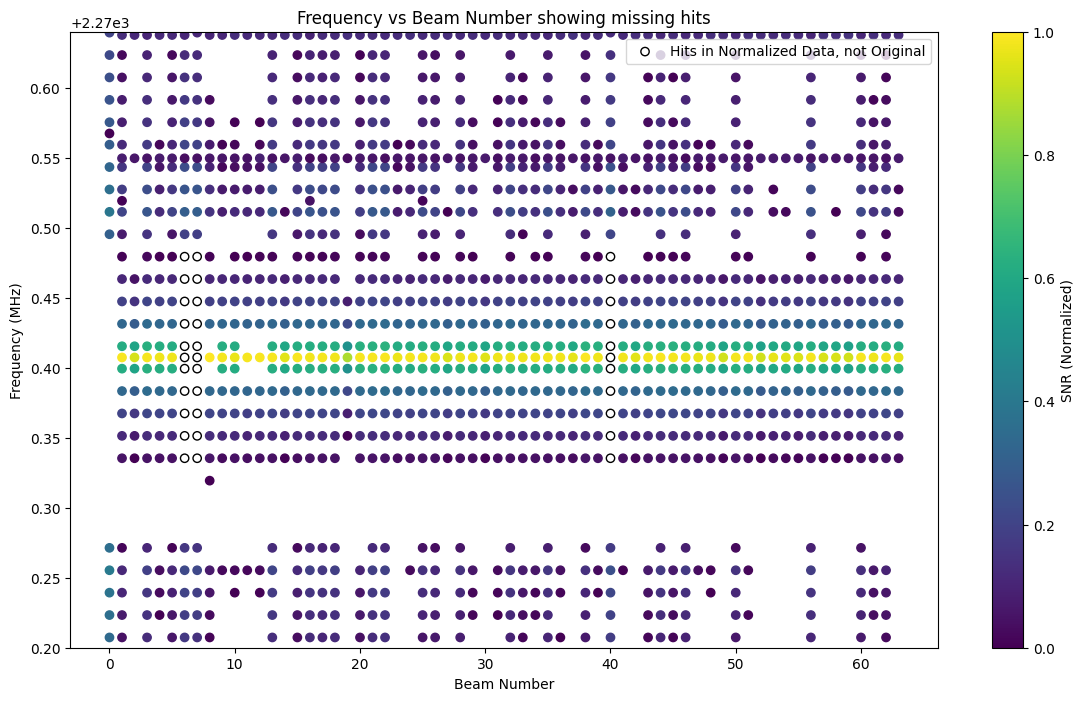

In [ ]:
plt.figure(figsize= (14, 8))
freq = df3['frequency']
snr_values = df3['snr']
snr_values = 10*np.log10(snr_values)
beam = df3['beam']
first_beam = beam.iloc[:, 0]   
         
plt.scatter(first_beam, freq, c=snr_values, cmap='viridis')

freq = merged_df['frequency']
snr_values = merged_df['snr']
snr_values = 10*np.log10(snr_values)
beam = merged_df['beam']
first_beam = beam.iloc[:, 0]   
         
plt.scatter(first_beam, freq, edgecolor='black', facecolor='none', marker='o', label='Hits in Normalized Data, not Original')
plt.scatter(beam0snr, beam0freq, edgecolors= 'black', facecolor= 'none')
print(beam0snr)

plt.colorbar(label='SNR (Normalized)')
plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Beam Number showing missing hits')
plt.ylim(2270.2, 2270.64)
plt.legend(frameon=True, title_fontsize='large')
plt.show()